In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
from scipy import io

from shape_detector import word_idx
import cusplets
import stat_tools as st

Round two of "Dave tells you how he feels about time series". Well, here is a new method for figuring out what is going on with cusps and shocks, and I have to say that I like it a lot better than the last one. It is more mathematically-sound. 

Let us look at the same pair of these time series again.

[-6573.5 -7909.  -7273.  ...   -75.   -104.    -93. ]


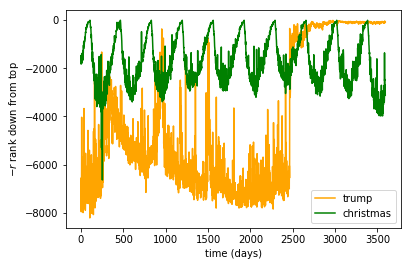

In [7]:
# we were provided with a matlab-style file.....
mat = io.loadmat('rank_turbulence_extractorify006_spearman.mat')

# some example words
trump = mat['ok_wordranks'][word_idx('trump', mat['ok_words']), :].T
trump = -np.squeeze(trump)

christmas = mat['ok_wordranks'][word_idx('christmas', mat['ok_words']), :].T
christmas = -np.squeeze(christmas)

plt.plot(trump, color='orange', label='trump')
plt.plot(christmas, 'g-', label='christmas')
plt.xlabel('time (days)')
plt.ylabel('$-r$ rank down from top')
plt.legend()
print(trump)

Great. Here is what we are going to do. We are looking for, as Dodds would put it, "piecewise-mechanistic" models. What kinds of mechanisms operate locally?

1.  $\dot{x} = ax$
2.  $\dot{x} = bx/t$
3.  $\dot{x} = \delta(t - t_0)$

This is a pretty reasonable list---we could expand it if we cared enough. The point is, each of these mechanisms locally generates a unique kernel up to shifting, scaling, and the group of reflections of the square about the Cartesian axes. In addition, we know that these kernels may be "turned on" or "turned off" exogenously by events, so we will multiply them by the Heaviside function. So the kernels we are working with are

$$
\begin{aligned}
\mathcal{K}_{power}(t, W) &\propto t^{b}H(t)[1-H(t - W)]\\
\mathcal{K}_{exp}(t, W) &\propto e^{at}H(t)[1-H(t - W)],
\end{aligned}
$$

along with the Haar wavelet.
We enforce that $\int_{-\infty}^{\infty} \mathcal{K}(t, W)\ dt = 0$ for any window size $W$. 
Now, for some window $W$ we will define the cusplet transform of the time series $x(t)$ as 

$$
\mathrm{C}_{\mathcal{K}}(\tau, W) = (x\star \mathcal{K})_W(\tau)
\equiv \displaystyle\int_{-\infty}^{\infty} x^{\dagger}(t)\mathcal{K}(t + \tau, W + \tau)\ dt,
$$

the cross-correlation of the sequence and the kernel. In this way it is similar to the wavelet transform, but using cross-correlation instead of convolution and with particular functional kernel forms that come from physical considerations.
We then define the cusp (or shock) indicator as the function 

$$
\mathrm{C}_{\mathcal{K}}(\tau) = \sum_W \mathrm{C}_{\mathcal{K}}(\tau, W),
$$

for all windows $W$ considered; this aggregates behavior at all scales.

Denote the group of reflections of the square as $R_4$.
For any _symmetric_ version of the cusplets defined above, there exist elements $r_1,r_2 \in R_4$ so that the symmetric version can be written 

$$
\mathcal{K}_{sym} = r_1 \mathcal{K} + r_2\mathcal{K}.
$$

These are all the pieces that we need. Let's see it in action. We will start with a symmetric power kernel as a hypothesis for a generating mechanism of cusps, and a Haar wavelet as a generarting mechanism for shocks.

In [3]:
window_widths = range(10, 750, 2)
power_exponent = 3
std_mult = 0.75

cc, cc_kern = cusplets.cusplet(trump,
                              cusplets.power_cusp,
                              window_widths,
                              [power_exponent])
cusps, cusp_indic = cusplets.classify_cusps(cc, b=std_mult)

ss, ss_kern = cusplets.cusplet(trump,
                              cusplets.haar,
                              window_widths,
                              [])
shocks, shocks_indic = cusplets.classify_cusps(ss, b=std_mult)

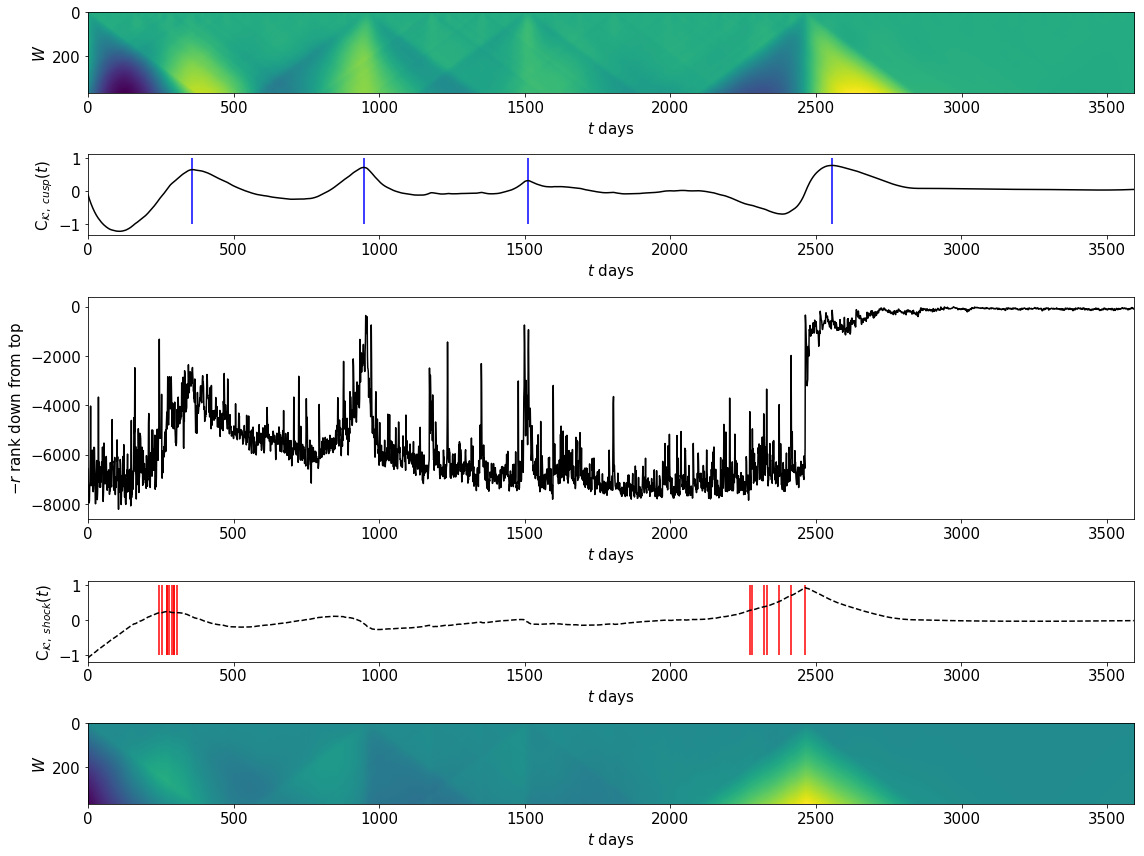

In [4]:
fig = plt.figure(figsize=(16, 12))

fsize = (6, 1)
xmin = 0
xmax = len(trump)

ax = plt.subplot2grid(fsize,
                      (2, 0),
                      rowspan=2)
ax1 = plt.subplot2grid(fsize,
                      (0, 0))
ax2 = plt.subplot2grid(fsize,
                      (1, 0))
ax3 = plt.subplot2grid(fsize,
                      (4, 0))
ax4 = plt.subplot2grid(fsize,
                      (5, 0))


ax.plot(trump, 'k-')
ax.set_ylabel('$-r$ rank down from top', fontsize=15)
ax.set_xlim(xmin, xmax)

ax2.plot(cusp_indic, 'k-')
ax2.vlines(cusps, -1, 1, color='b')
ax2.set_ylabel('$\\mathrm{C}_{\mathcal{K},\ cusp}(t)$', fontsize=15)
ax2.set_xlim(xmin, xmax)

ax3.plot(shocks_indic, 'k--')
ax3.vlines(shocks, -1, 1, color='r')
ax3.set_ylabel('$\\mathrm{C}_{\mathcal{K},\ shock}(t)$', fontsize=15)
ax3.set_xlim(xmin, xmax)

ax1.imshow(cc, aspect='auto')
ax1.set_ylabel('$W$', fontsize=15)

ax4.imshow(ss, aspect='auto')
ax4.set_ylabel('$W$', fontsize=15)


for a in [ax, ax1, ax2, ax3, ax4]:
    a.set_xlabel('$t$ days', fontsize=15)
    a.tick_params(labelsize=15)


plt.tight_layout()

plt.savefig('figures/cusplet_trump_demo.pdf')
plt.savefig('figures/cusplet_trump_demo.png')

Pretty cool! Now we will do the same thing for the far more regular time series "christmas".

In [5]:
window_widths = range(10, 750, 2)
power_exponent = 3
std_mult = 0.75

cc, cc_kern = cusplets.cusplet(christmas,
                              cusplets.power_cusp,
                              window_widths,
                              [power_exponent],
                              reflection=0)
cusps, cusp_indic = cusplets.classify_cusps(cc, b=std_mult)

ss, ss_kern = cusplets.cusplet(christmas,
                              cusplets.haar,
                              window_widths,
                              [])
shocks, shocks_indic = cusplets.classify_cusps(ss, b=std_mult)

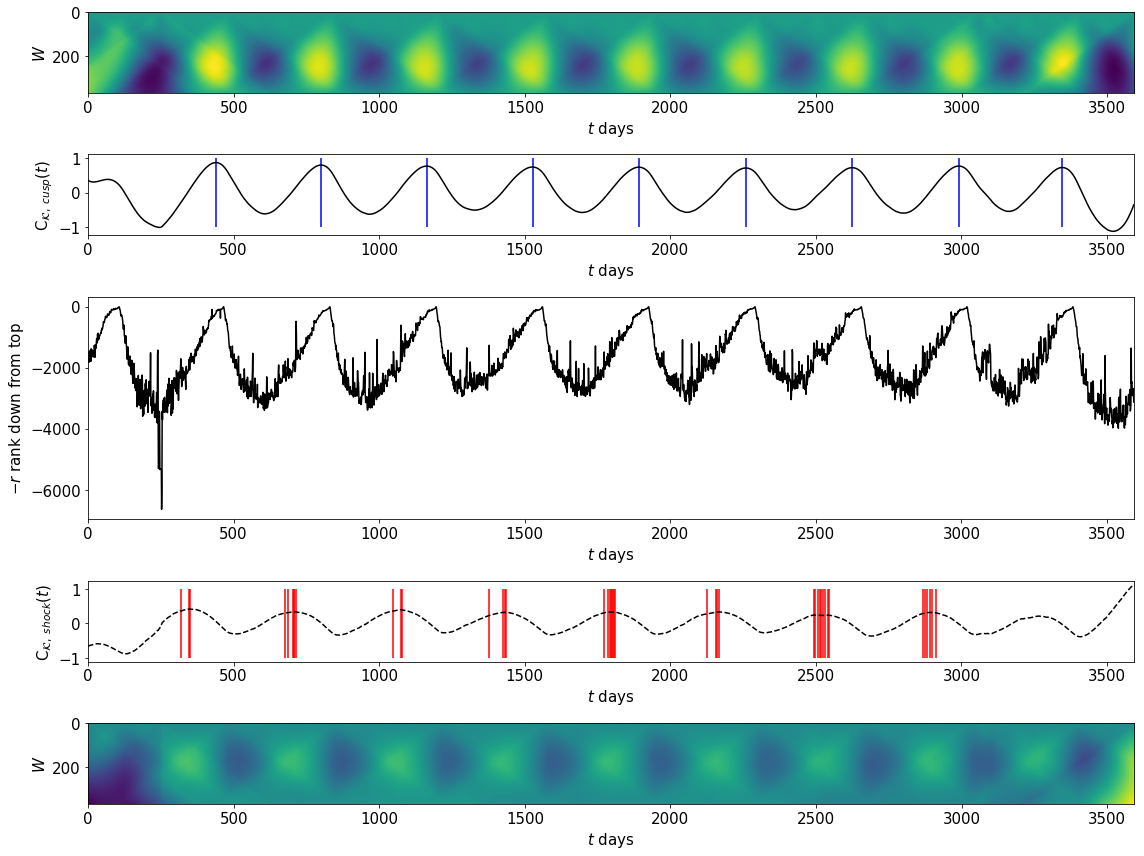

In [6]:
fig = plt.figure(figsize=(16, 12))

fsize = (6, 1)
xmin = 0
xmax = len(trump)

ax = plt.subplot2grid(fsize,
                      (2, 0),
                      rowspan=2)
ax1 = plt.subplot2grid(fsize,
                      (0, 0))
ax2 = plt.subplot2grid(fsize,
                      (1, 0))
ax3 = plt.subplot2grid(fsize,
                      (4, 0))
ax4 = plt.subplot2grid(fsize,
                      (5, 0))


ax.plot(christmas, 'k-')
ax.set_ylabel('$-r$ rank down from top', fontsize=15)
ax.set_xlim(xmin, xmax)

ax2.plot(cusp_indic, 'k-')
ax2.vlines(cusps, -1, 1, color='b')
ax2.set_ylabel('$\\mathrm{C}_{\mathcal{K},\ cusp}(t)$', fontsize=15)
ax2.set_xlim(xmin, xmax)

ax3.plot(shocks_indic, 'k--')
ax3.vlines(shocks, -1, 1, color='r')
ax3.set_ylabel('$\\mathrm{C}_{\mathcal{K},\ shock}(t)$', fontsize=15)
ax3.set_xlim(xmin, xmax)

ax1.imshow(cc, aspect='auto')
ax1.set_ylabel('$W$', fontsize=15)

ax4.imshow(ss, aspect='auto')
ax4.set_ylabel('$W$', fontsize=15)


for a in [ax, ax1, ax2, ax3, ax4]:
    a.set_xlabel('$t$ days', fontsize=15)
    a.tick_params(labelsize=15)


plt.tight_layout()

plt.savefig('figures/cusplet_christmas_demo.pdf')
plt.savefig('figures/cusplet_christmas_demo.png')

Very interesting. We note the periodicity of shocks also, as Christmas is suddenly talked about much more at the very beginning of each lead-up to the actual day.

Now let's make some videos.

In [13]:
lag = int(365/3)
words = ['trump', 'obama', 'hillary', 'clinton', 'christmas', 'summer', 'happy']
inds = [word_idx(word, mat['ok_words'])[0] for word in words]

In [ ]:
res = {}
window_widths = range(10, lag, 2)
power_exponent = 3
fsize = (6, 1)

for i, (word, ind) in enumerate(zip(words, inds)):
    print(f'on {word}')
    X = mat['ok_wordranks'][word_idx(word, mat['ok_words']), :].T
    X = -np.squeeze(X)
    X = st.make_moving_tensor(X, lag)
    
    cc_s = []
    ss_s = []
    cusps = []
    shocks = []
    
    path_ = 'figures/videos/' + word + '/'

    if not os.path.exists(os.path.dirname(path_)):
        try:
            os.makedirs(os.path.dirname(path_))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
    ll = len(X)
    
    for j, x in enumerate(X):
        if j % 100 == 0:
            print(f'on {j} of {ll}')
        cc, cc_kern = cusplets.cusplet(x,
                                  cusplets.power_zero_cusp,
                                  window_widths,
                                  [power_exponent],
                                  reflection=1)
        cusps, cusp_indic = cusplets.classify_cusps(cc, b=std_mult)

        ss, ss_kern = cusplets.cusplet(x,
                                      cusplets.haar,
                                      window_widths,
                                      [])
        shocks, shocks_indic = cusplets.classify_cusps(ss, b=std_mult)

        fig = plt.figure(figsize=(16, 12))
        xmin = 0
        xmax = len(x)

        ax = plt.subplot2grid(fsize,
                              (2, 0),
                              rowspan=2)
        ax1 = plt.subplot2grid(fsize,
                              (0, 0))
        ax2 = plt.subplot2grid(fsize,
                              (1, 0))
        ax3 = plt.subplot2grid(fsize,
                              (4, 0))
        ax4 = plt.subplot2grid(fsize,
                              (5, 0))


        ax.plot(x, 'k-')
        ax.set_ylabel('$-r$ rank down from top', fontsize=15)
        ax.set_xlim(xmin, xmax)

        ax2.plot(cusp_indic, 'k-')
        ax2.vlines(cusps, -1, 1, color='b')
        ax2.set_ylabel('$\\mathrm{C}_{\mathcal{K},\ cusp}(t)$', fontsize=15)
        ax2.set_xlim(xmin, xmax)

        ax3.plot(shocks_indic, 'k--')
        ax3.vlines(shocks, -1, 1, color='r')
        ax3.set_ylabel('$\\mathrm{C}_{\mathcal{K},\ shock}(t)$', fontsize=15)
        ax3.set_xlim(xmin, xmax)

        ax1.imshow(cc, aspect='auto')
        ax1.set_ylabel('$W$', fontsize=15)

        ax4.imshow(ss, aspect='auto')
        ax4.set_ylabel('$W$', fontsize=15)


        for a in [ax, ax1, ax2, ax3, ax4]:
            a.set_xlabel('$t$ days', fontsize=15)
            a.tick_params(labelsize=15)

        plt.tight_layout()
        
        name = str(j)
        name = name.zfill(5)+'cusplet'
        plt.savefig(path_ + name + '.png', transparent=True)
        plt.close()